In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [7]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [20]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [21]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [22]:
# Save references to each table
Measurement= Base.classes.measurement
Station=Base.classes.station

In [23]:
# Create our session (link) from Python to the DB
session=Session(bind=engine)

In [24]:
# Get table info using inspector
inspector = inspect(engine)
measurement_columns = inspector.get_columns('Measurement')
station_columns = inspector.get_columns('Station')

# Display column names & data types for each table
print('Measurement:')
for columns in measurement_columns:
    print(columns['name'], columns['type'])
print('-'*12)
print('Station:')
for columns in station_columns:
    print(columns['name'], columns['type'])

Measurement:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
------------
Station:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [25]:
# Find the most recent date in the data set.
recent_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(recent_date)


('2017-08-23',)


2016-08-23 00:00:00


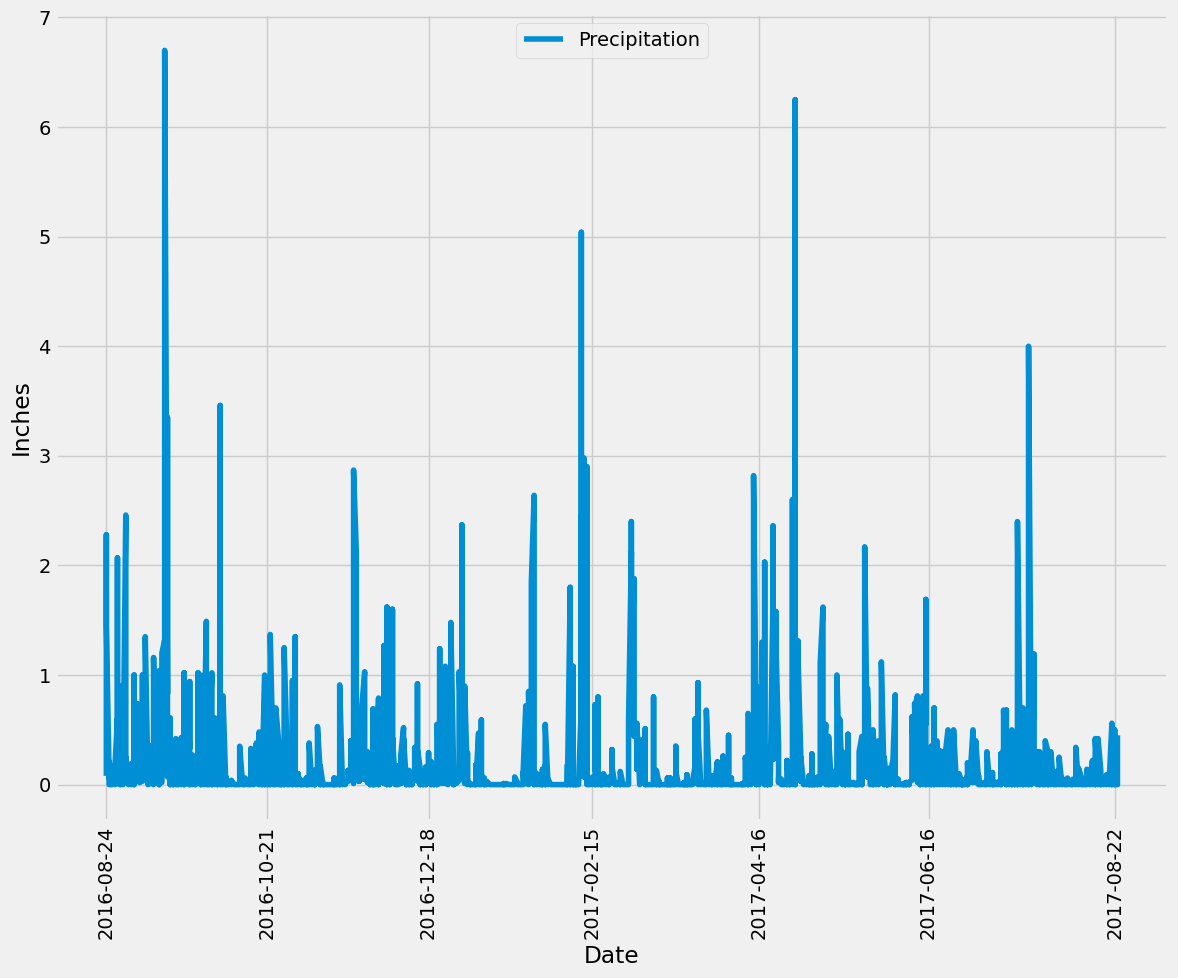

In [28]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_date = dt.datetime.strptime(recent_date[0], "%Y-%m-%d") - dt.timedelta(days=365)
print(last_date)

# Perform a query to retrieve the data and precipitation scores
data_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_date).order_by(Measurement.date).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(data_prcp, columns=['Date', 'Inches'])

df1=df.dropna(how="any")
# Sort the dataframe by date
df_sorted=df1.sort_values(by="Date")

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(12,10))
plt.plot(df_sorted["Date"], df_sorted["Inches"], label="Precipitation") 
plt.legend(loc="upper center")
plt.xlabel("Date")
plt.ylabel("Inches")
num_xlabels = 6
step = len(df_sorted) // num_xlabels
index_label = list(range(0, len(df_sorted), step))
Sample_date = df_sorted['Date'].iloc[index_label]
plt.xticks(Sample_date, rotation='vertical')

plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
# Use Pandas to calculate the summary statistics for the precipitation data
agg_functions = {
    'count': 'count',
    'mean': 'mean',
    'std': 'std',
    'min': 'min',
    '25th percentile': lambda x: x.quantile(0.25),
    '50th percentile': lambda x: x.quantile(0.50),
    '75th percentile': lambda x: x.quantile(0.75),
    'max': 'max'
}

Summary_stat = pd.DataFrame(df_sorted['Inches'].agg(agg_functions))
Summary_stat.rename(columns={'Inches': 'Precipitation'}, inplace=True)
Summary_stat

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25th percentile,0.000000
50th percentile,0.020000
75th percentile,0.130000
max,6.700000


# Exploratory Station Analysis

In [30]:
# Design a query to calculate the total number of stations in the dataset
numstations = session.query(Measurement).group_by(Measurement.station).count()
print(numstations)

9


In [39]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
act_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

act_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [45]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
stat_station = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == act_stations[0].station).all()
print(stat_station)

[(54.0, 85.0, 71.66378066378067)]


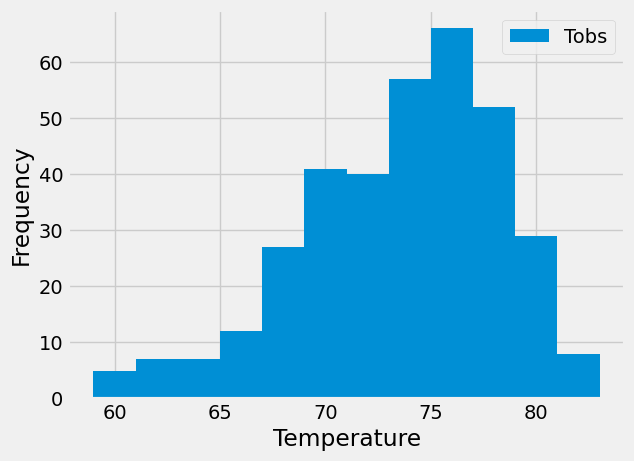

In [47]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
twelve_temps = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == act_stations[0].station).filter(Measurement.date >= last_date)

# Create a dataframe to hold this query data for graphing
df2 = pd.DataFrame(twelve_temps, columns=['Date', 'Tobs'])

# Set index to the 'Date' column & sort by date
tobs = df2.set_index('Date').sort_index()

# Plot the results as a histogram
tobs.plot(kind='hist', bins=12)
plt.xlabel('Temperature')
plt.show()

# Close Session

In [50]:
# Close Session
session.close()